姓名：李品慈
學號：0816039

## Data input

In [1]:
# importing library
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tensorflow.keras.callbacks import TensorBoard
import time

#NAME = "Category-CNN-128x2-epoch5-{}".format(int(time.time()))

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import datas  
with open('train.json') as f:
    train = json.load(f)
    
with open('test.json') as f:
    test = json.load(f)


train_data = pd.json_normalize(train)
train_data.to_csv("train.csv")
test_data = pd.json_normalize(test)
test_data.to_csv("test.csv")

In [2]:
train_data.head()

,id,cuisine,ingredients
0,42302,southern_us,"[egg whites, pecans, agave nectar, ground cinn..."
1,43202,greek,"[large egg whites, whole milk, bread crumb fre..."
2,31619,cajun_creole,"[sugar, vegetable oil, yeast, eggs, evaporated..."
3,30920,korean,"[honey, rice vinegar, brown sugar, ginger, gar..."
4,46567,italian,"[mushroom caps, asiago, large shrimp, fat free..."


In [3]:
len(train)

29774

In [4]:
# count how much unique cuisine
len(train_data['cuisine'].value_counts())

20

In [5]:
test_data.head()

,id,ingredients
0,14,"[olive oil, balsamic vinegar, toasted pine nut..."
1,22,"[canola, jalapeno chilies, salsa, onions, cide..."
2,24,"[large eggs, vanilla extract, firmly packed li..."
3,37,"[queso fresco, margarine, chicken breasts, ext..."
4,40,"[active dry yeast, white sugar, warm water, sa..."


## Data Visualization

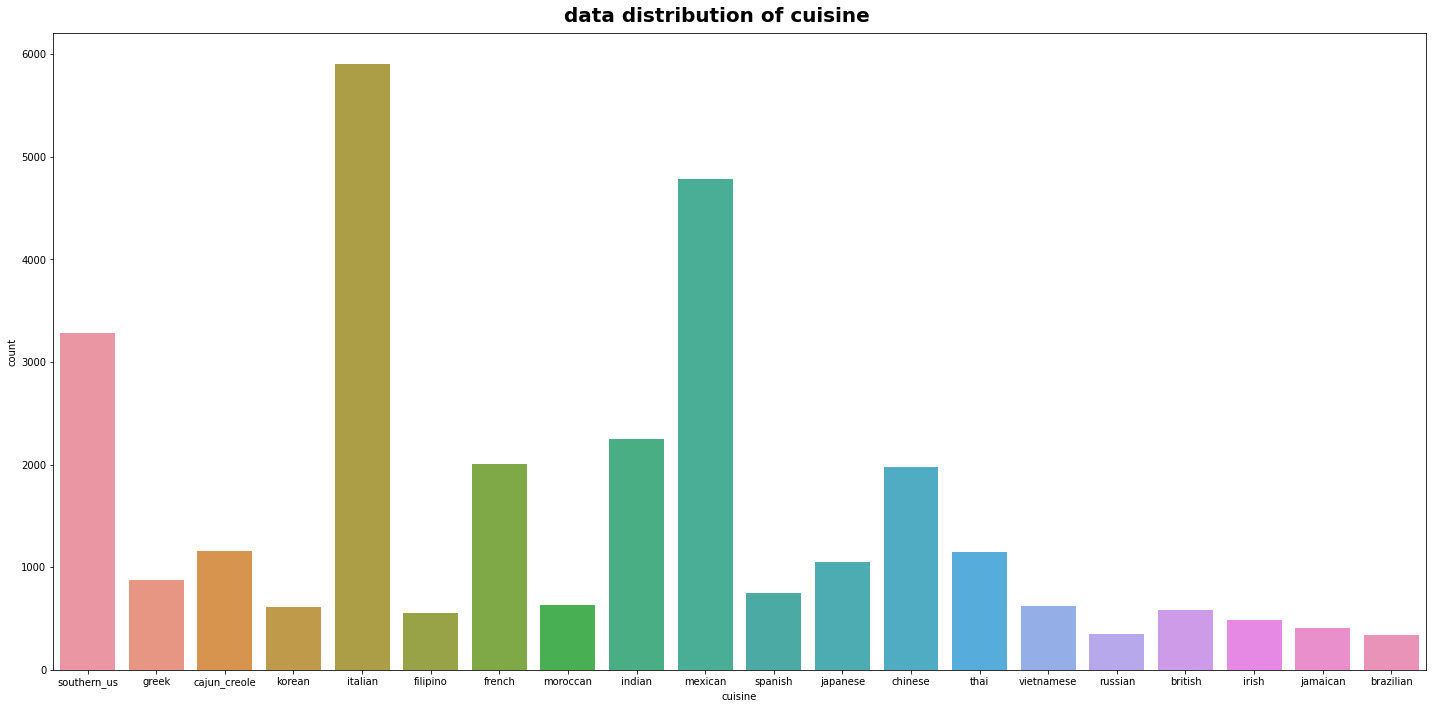

In [6]:
# draw subplots
plt.figure(figsize=(20,10))
plt.suptitle('data distribution of cuisine', fontweight="bold", size=20)

sns.countplot(x = train_data['cuisine'])
plt.tight_layout()

In [7]:
from itertools import chain
from collections import Counter

l = []
#l = ['apple','banana','tomato'],['tomato','tree','pikachu']
for row in train_data['ingredients']:
    l.append(row)

value_count = Counter(chain(*l)).most_common(30)
value_count = dict(value_count)

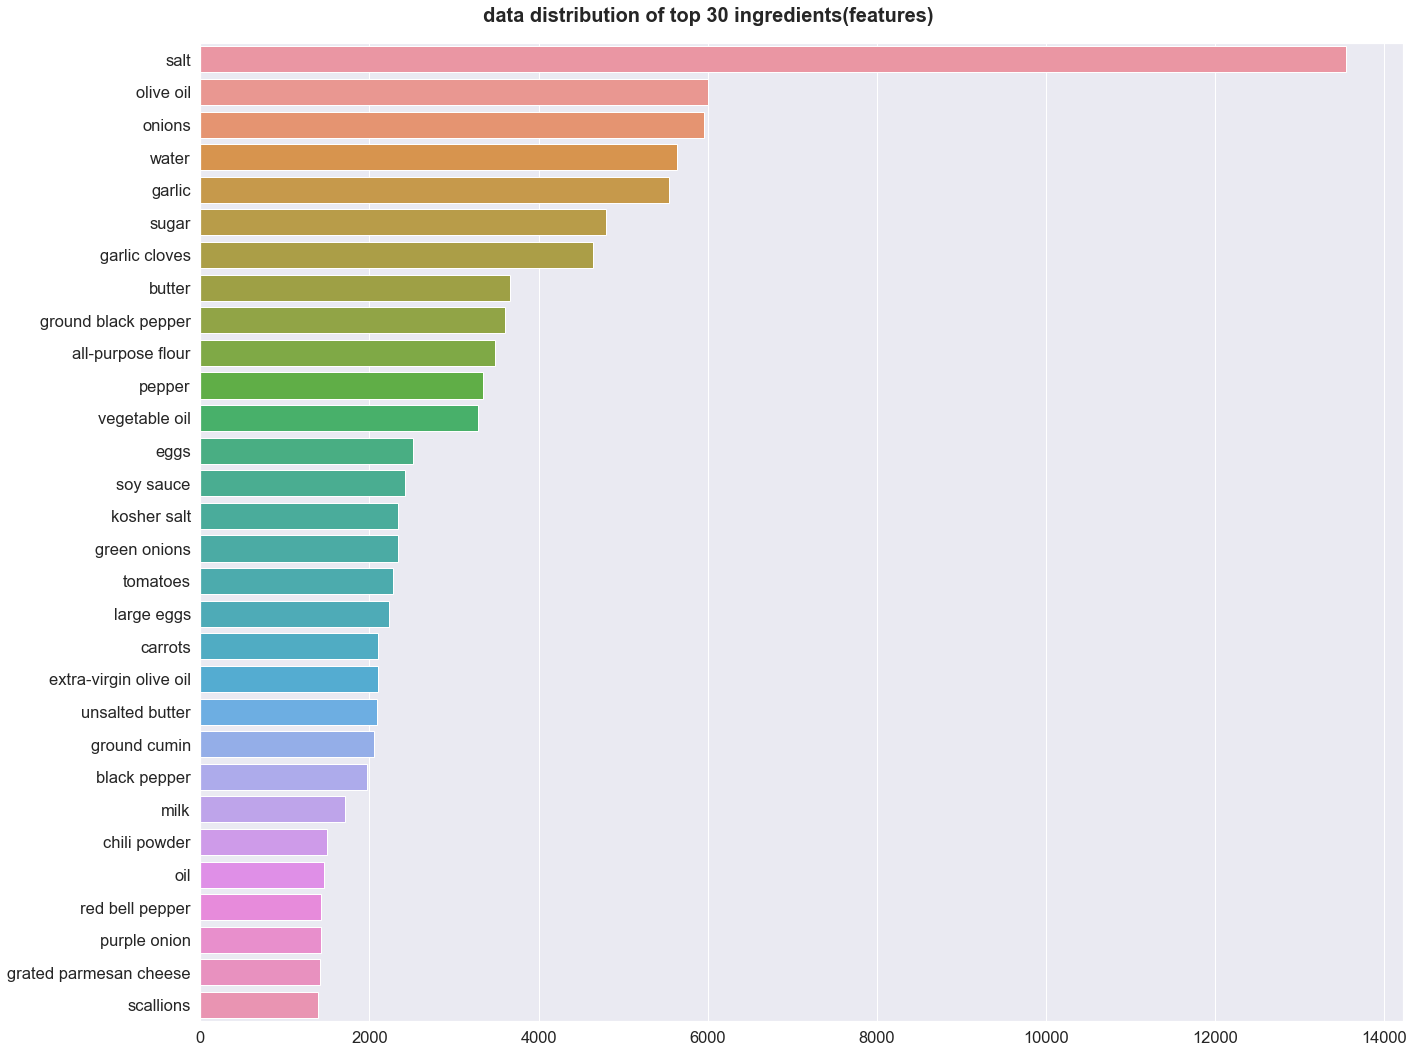

In [8]:
# get values in the same order as keys, and parse percentage values
keys = list(value_count.keys())
vals = [(value_count[k]) for k in keys]

plt.figure(figsize=(20,15))
sns.set(font_scale=1.5)
plt.suptitle('data distribution of top 30 ingredients(features)', fontweight="bold", size=20)
sns.barplot(x=vals, y=keys, orient = 'h')
plt.tight_layout()

In [9]:
num_of_ing = []
for row in train_data['ingredients']:
    num_of_ing.append(len(row))
    
num_of_ing[:5]

[5, 11, 11, 10, 12]

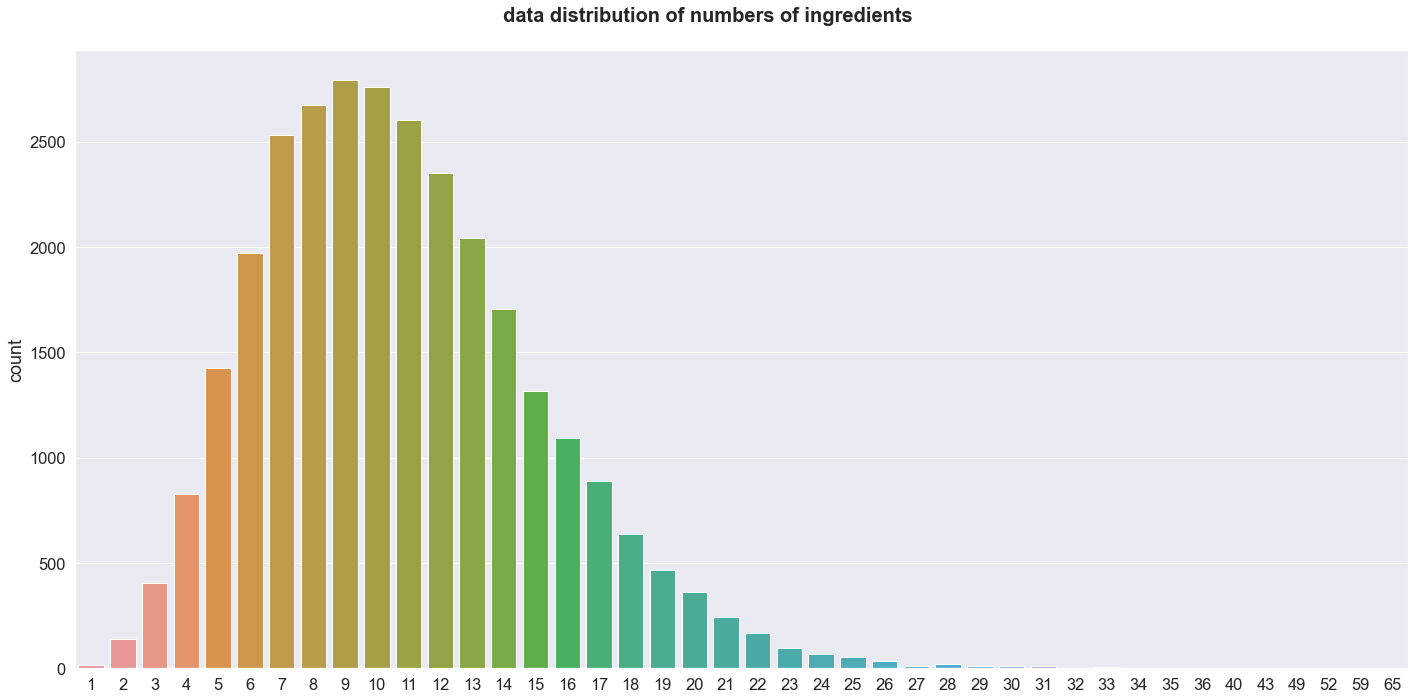

In [10]:
# draw subplots
plt.figure(figsize=(20,10))
plt.suptitle('data distribution of numbers of ingredients', fontweight="bold", size=20)

sns.countplot(x = num_of_ing)
plt.tight_layout()

## Data preprocessing

In [11]:
train_data.head()

,id,cuisine,ingredients
0,42302,southern_us,"[egg whites, pecans, agave nectar, ground cinn..."
1,43202,greek,"[large egg whites, whole milk, bread crumb fre..."
2,31619,cajun_creole,"[sugar, vegetable oil, yeast, eggs, evaporated..."
3,30920,korean,"[honey, rice vinegar, brown sugar, ginger, gar..."
4,46567,italian,"[mushroom caps, asiago, large shrimp, fat free..."


In [12]:
test_data.head()

,id,ingredients
0,14,"[olive oil, balsamic vinegar, toasted pine nut..."
1,22,"[canola, jalapeno chilies, salsa, onions, cide..."
2,24,"[large eggs, vanilla extract, firmly packed li..."
3,37,"[queso fresco, margarine, chicken breasts, ext..."
4,40,"[active dry yeast, white sugar, warm water, sa..."


In [13]:
import re

# Transform data format and shape so your model can process them.
# split the ingredient array into indipendent rows
train_data = train_data.set_index(['id','cuisine']).ingredients.apply(pd.Series).stack().reset_index(['id','cuisine'], name='ingredients')
test_data = test_data.set_index(['id']).ingredients.apply(pd.Series).stack().reset_index(['id'], name='ingredients')

# remove the (10 oz.), (   oz.) thingy
pattern = '\(([1-9]*[0-9]*)*\ *oz\.\)\ '
train_data['ingredients'] = train_data['ingredients'].str.replace(pattern, '')
pattern = '\(([1-9]*[0-9]*(\.?))*\ *oz\.\) '
test_data['ingredients'] = test_data['ingredients'].str.replace(pattern, '')

# numerize the categorical indegredients
# Concat with keys
temp = pd.get_dummies(pd.concat([train_data,test_data],keys=[0,1]), columns=['ingredients'])

# Selecting data from multi index 
train_data, test_data = temp.xs(0),temp.xs(1)

# fill in nan
train_data.fillna(0)
test_data.fillna(0)

train_data.head()

,id,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
0,42302,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,42302,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42302,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42302,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42302,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test_data.head()

,id,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
0,14,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# merge all the rows that have same id and cuisine
temp = train_data.groupby(['id', 'cuisine'], as_index=False, sort = False).max()
temp2 = test_data.groupby(['id'], as_index=False, sort = False).max()

temp.head()

,id,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
0,42302,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43202,greek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31619,cajun_creole,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30920,korean,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,46567,italian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# check the shape of the merged data, we have 29774 originally, so if this is not 29774, then we got a big problem
temp.shape

(29774, 6709)

In [17]:
# check if the preprocessing works fine
temp[temp['ingredients_yuzu'] == 1]

,id,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
15969,1419,japanese,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22790,32334,japanese,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
29307,20623,japanese,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [18]:
# set the id as the dataframe index
train_data = temp.set_index('id') # set id as the dataframe's index
test_data = temp2.set_index('id')

train_data.head()

,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,ingredients_2% milk shredded mozzarella cheese,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
id,,,,,,,,,,,,,,,,,,,,,
42302,southern_us,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43202,greek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31619,cajun_creole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30920,korean,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46567,italian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Shuffle the data
train_data = train_data.sample(frac=1)

# Any other transformation boosts the final performance
################## Maybe do something here ########################


########################### END ##########################

train_data.head()

,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,ingredients_2% milk shredded mozzarella cheese,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
id,,,,,,,,,,,,,,,,,,,,,
39461,chinese,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6794,russian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1401,greek,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
18417,french,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26852,italian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Artificial Neural Networks w/ holdout validation

In [20]:
from sklearn.model_selection import train_test_split

train_class = train_data['cuisine']
train_ingredients = train_data.drop('cuisine', axis = 1)

X_train,X_test,y_train,y_test=train_test_split(train_ingredients,train_class,test_size=0.3)

In [21]:
y_train[:5]

id
21406    southern_us
19267    southern_us
3351         italian
8642         italian
44558    southern_us
Name: cuisine, dtype: object

In [22]:
y_test[:5]

id
20811    southern_us
2995         mexican
3485         mexican
47949         indian
22906        italian
Name: cuisine, dtype: object

In [23]:
# import lib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn import preprocessing

model = Sequential()

# Add Input layer hidden layer with 128 neuros
model.add(Dense(units=128, activation='relu')) 
model.add(Dense(128, activation='relu'))

# Add output layer
model.add(Dense(units=20, activation='softmax'))

# compile and choose the loss, optimizer, and validation method
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# encode cuisine labels
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)  

# train
model.fit(X_train, y_train, epochs=3)#, callbacks=[tensorboard])

Epoch 1/3
652/652 [==============================] - 3s 4ms/step - loss: 1.1940 - accuracy: 0.6631
Epoch 2/3
652/652 [==============================] - 2s 4ms/step - loss: 0.5711 - accuracy: 0.8347
Epoch 3/3
652/652 [==============================] - 3s 4ms/step - loss: 0.3702 - accuracy: 0.8876


在model的部份我選擇了sequential，沒有選擇funcional是因為這裡不會用到functional的多數功能，太flexible也很難決定要設定的參數，所以這裡選了比較簡單好用的sequential。
在input後會有128x2的layer，經測試後這個組合比較剛好，丟進kaggle後的predict也較為準確。
activation和optimizer則是選擇了最common的softmax跟adam。
model compile後就讓他進行3次的training。

In [24]:
list(le.classes_)

['brazilian',
 'british',
 'cajun_creole',
 'chinese',
 'filipino',
 'french',
 'greek',
 'indian',
 'irish',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'mexican',
 'moroccan',
 'russian',
 'southern_us',
 'spanish',
 'thai',
 'vietnamese']

## Results

+------------+----------+-------------+
|   accuracy |   recall |   precision |
+============+==========+=============+
|   0.758984 | 0.652181 |    0.702712 |
+------------+----------+-------------+


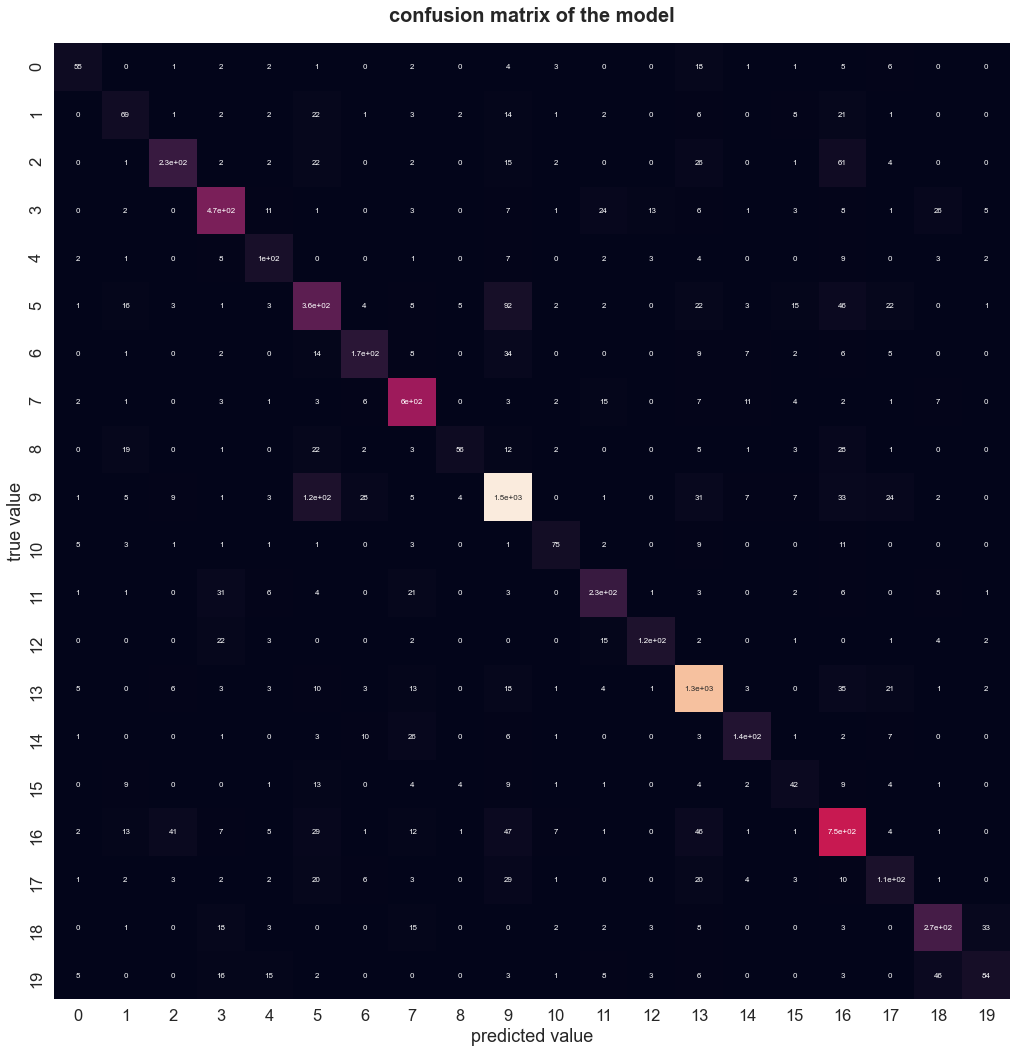

In [25]:
# import lib
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tabulate import tabulate

y_predict = np.argmax(model.predict(X_test), axis=-1)

# results: confusion matrix
plt.figure(figsize=(25,15))
plt.suptitle('confusion matrix of the model', fontweight="bold", size=20)

mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat,square= True, annot=True, cbar= False, annot_kws={"size": 8})
plt.xlabel("predicted value")
plt.ylabel("true value")
#plt.show()
plt.tight_layout()

# results: accuracy
accuracy = accuracy_score(y_test, y_predict)

# results: sensitivity(recall)
recall = recall_score(y_test, y_predict, average='macro')

# results: precision
precision = precision_score(y_test, y_predict, average='macro')

# draw table with accuracy, recall, precision
data = [[accuracy, recall, precision]]

headers = ["accuracy", "recall", "precision"]

print(tabulate(data, headers= headers, tablefmt= "grid"))

從上圖可以看出，這個model在accuracy的部分表現較好，判斷true positive & positive case的recall較弱。我們可以由下面的confusion matrix更仔細來看。
推測造成這個的原因有二：
   1. 因為某些category容易與特定的另一個category搞混（或因文化上相近），例如：true value = 5的french容易與true value = 9的italien。
   2. 相關資料較少，抑或ingredient較無特點，例如：true value = 0的brazilien, true value = 8的irish。

## Kaggle submission

In [26]:
test_data.head()

,cuisine,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,ingredients_2% milk shredded mozzarella cheese,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
id,,,,,,,,,,,,,,,,,,,,,
14,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
verifying_data = test_data.drop('cuisine', axis = 1)

verifying_data

,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,ingredients_2% milk shredded mozzarella cheese,ingredients_2% reduced-fat milk,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
id,,,,,,,,,,,,,,,,,,,,,
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# check if the preprocessing works fine
verifying_data[verifying_data['ingredients_yuzu'] == 1]

,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,ingredients_2% milk shredded mozzarella cheese,ingredients_2% reduced-fat milk,...,ingredients_yukon gold potatoes,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms
id,,,,,,,,,,,,,,,,,,,,,
6245,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
39669,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [29]:
predictions = np.argmax(model.predict(verifying_data), axis=-1)
# get prediction result
print(predictions)

[ 9 13 16 ...  9  9  6]


In [30]:
predictions = list(le.inverse_transform(predictions))

In [31]:
len(predictions)

10000

In [32]:
predictions = pd.DataFrame(predictions, columns = ['Category'])

predictions

,Category
0,italian
1,mexican
2,southern_us
3,mexican
4,british
...,...
9995,southern_us
9996,southern_us
9997,italian
9998,italian


In [33]:
verifying_data['Category'] = np.array(predictions)
output_csv = verifying_data

output_csv

,ingredients_1% low-fat buttermilk,ingredients_1% low-fat chocolate milk,ingredients_1% low-fat cottage cheese,ingredients_1% low-fat milk,"ingredients_2 1/2 to 3 lb. chicken, cut into serving pieces",ingredients_2% low fat cheddar chees,ingredients_2% low-fat cottage cheese,ingredients_2% lowfat greek yogurt,ingredients_2% milk shredded mozzarella cheese,ingredients_2% reduced-fat milk,...,ingredients_yuzu,ingredients_yuzu juice,ingredients_za'atar,ingredients_zest,ingredients_zesty italian dressing,ingredients_zinfandel,ingredients_ziti,ingredients_zucchini,ingredients_zucchini blossoms,Category
id,,,,,,,,,,,,,,,,,,,,,
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,italian
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mexican
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mexican
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,british
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
49693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
49697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,italian


In [35]:
output_csv = output_csv['Category']


output_csv

id
14           italian
22           mexican
24       southern_us
37           mexican
40           british
            ...     
49692    southern_us
49693    southern_us
49697        italian
49709        italian
49710          greek
Name: Category, Length: 10000, dtype: object

In [36]:
output_csv.to_csv("C:/Users/sunny/Desktop/Senior/Introduction to Machine Learning/Lab/Lab5/1217_layer2_epoch3_node128.csv")

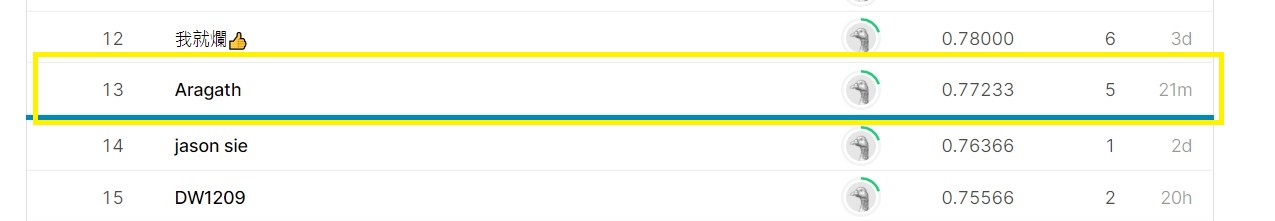

In [42]:
from IPython.display import Image

Image(filename='leader board.jpg') 